# Hydrogel-Cell Interaction Test Case

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os, glob
from itertools import permutations
import pyshtools

sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord, GLQCartCoord
from shelastic.shutil import SHCilmToVector, SHVectorToCilm, SHVec2mesh, SHmesh2Vec
from shelastic.shutil import TransMat, l_coeffs, m_coeffs, LM_list, lmk2K, K2lmk
from shelastic.shbv import generate_submat, Uvec2Tvec, Tvec2Uvec
from shelastic.shvis  import plotfv, vismesh, visSHVec, visSH3d
from sphere_utils import loadCoeffs, arbitrary_force, Ur_interp
from sphere_utils import usurf2umesh, dumesh_dus, usurf2vec
from sphere_utils import Tvec2Tres, usurf2dr, calculateTfv, genSmat, genLmat, grad_usurf2dr

## Summary of traction accuracy given different noise level

In [2]:
shapename = 'noise'

# Material properties
mu0 = 300/3; nu0 = 0.499;
r0 = 5;           # microns
lJmax = lKmax = 20; lmax_plot = 60;

############################# Load UK and TK coefficients ##############################
Cmat, Dmat = loadCoeffs(mu0, nu0, lJmax, 'reg')

Integrating modes to a matrix
1323 1323
Integrating modes to a matrix
1323 1323


In [3]:
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
lon0, lat0 = np.meshgrid(lonsdeg, latsdeg)
X0shear = np.stack([lat0, lon0], axis=-1)
X0 = r0 * GLQCartCoord(lJmax)

In [4]:
lmax = lJmax
ldamp_hi = lmax; ldamp_lo = lmax - 5;
lv, _ = LM_list(lmax); lv_ones = np.ones_like(lv);
lv_lim = np.minimum(np.maximum(lv, ldamp_lo), ldamp_hi)
ldamp = (np.maximum(lv_lim-ldamp_lo, 0) / (ldamp_hi - ldamp_lo))**1
Q = spm.csr_matrix(np.diag(np.tile(ldamp, 3)).astype(np.complex))

### CASE 0 -- beta:   1.0e+00 gamma:   3.0e-01 rcut/r0:   0.3 noise:  0.01um ###
shape fitting accuracy: 1.433231997638668e-07
Traction residual: 1.5029e+00 Pa
Elastic energy: 3.9721e-04 pJ (true energy 3.9976e-04 pJ)
funval: 2.2587e-04 3.1777e-02 8.0166e-05
Traction error (Pa): emax_Tn =      8.38012478Pa emax_Ts =     10.49776724Pa


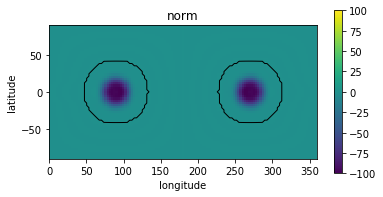

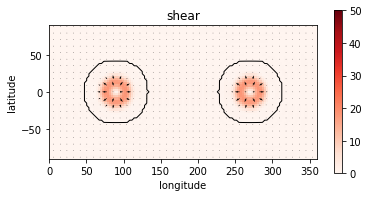

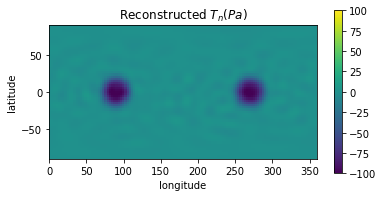

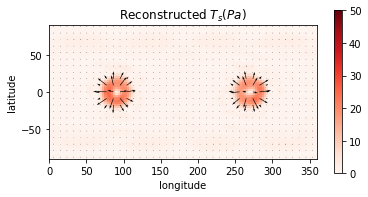

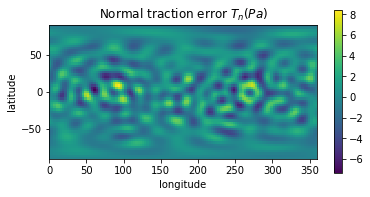

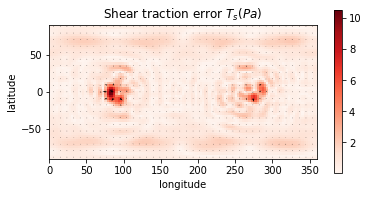

### CASE 1 -- beta:   1.0e+00 gamma:   5.0e-01 rcut/r0:   0.3 noise:  0.01um ###
shape fitting accuracy: 1.433231997638668e-07
Traction residual: 1.6059e+00 Pa
Elastic energy: 3.9917e-04 pJ (true energy 3.9976e-04 pJ)
funval: 2.5791e-04 3.1934e-02 8.4797e-05
Traction error (Pa): emax_Tn =      9.97758645Pa emax_Ts =     11.13958368Pa


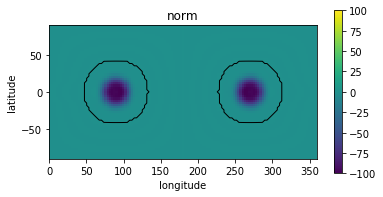

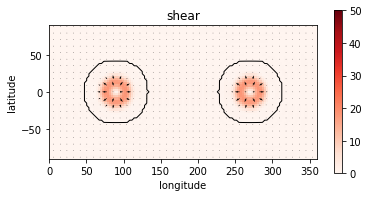

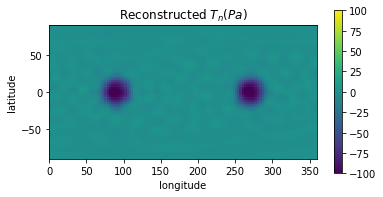

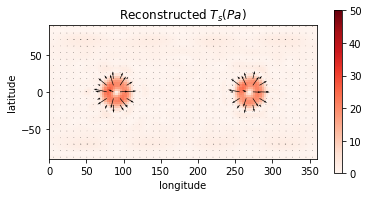

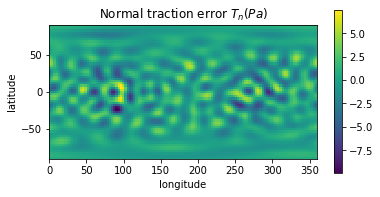

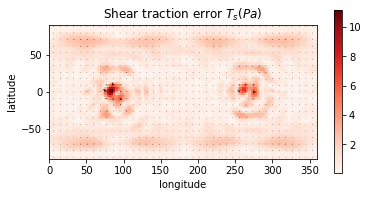

### CASE 2 -- beta:   1.0e+00 gamma:   7.0e-01 rcut/r0:   0.3 noise:  0.01um ###
shape fitting accuracy: 1.433231997638668e-07
Traction residual: 1.5665e+00 Pa
Elastic energy: 3.9566e-04 pJ (true energy 3.9976e-04 pJ)
funval: 2.4540e-04 3.1652e-02 7.8720e-05
Traction error (Pa): emax_Tn =      8.07817743Pa emax_Ts =      5.91316958Pa


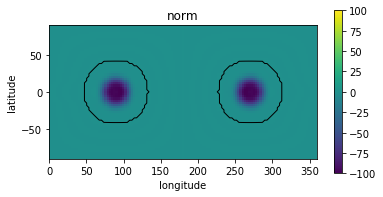

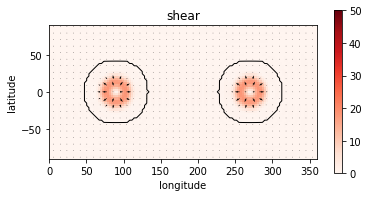

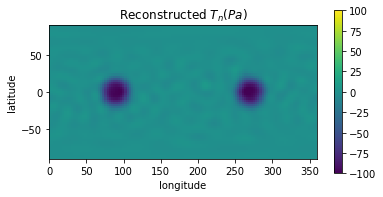

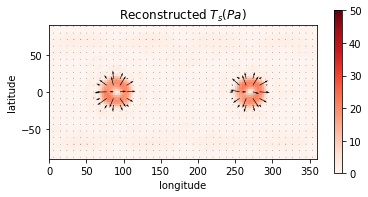

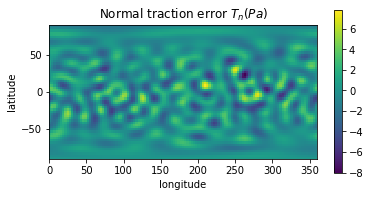

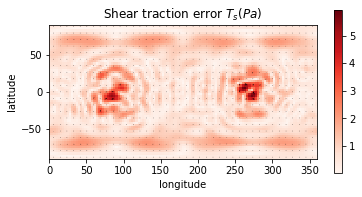

### CASE 3 -- beta:   1.0e+00 gamma:   8.0e-01 rcut/r0:   0.3 noise:  0.01um ###
shape fitting accuracy: 1.433231997638668e-07
Traction residual: 1.7041e+00 Pa
Elastic energy: 3.9736e-04 pJ (true energy 3.9976e-04 pJ)
funval: 2.9039e-04 3.1789e-02 8.6767e-05
Traction error (Pa): emax_Tn =      7.94070906Pa emax_Ts =      7.70355409Pa


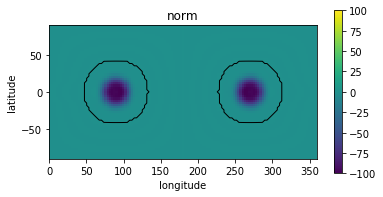

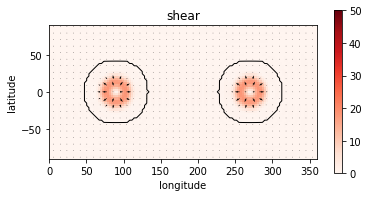

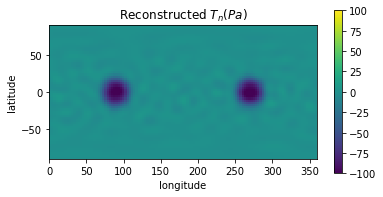

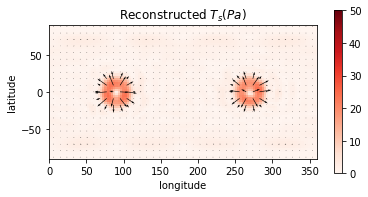

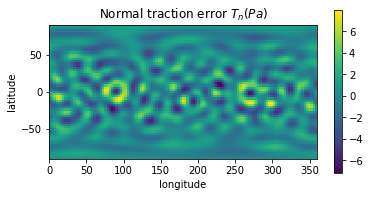

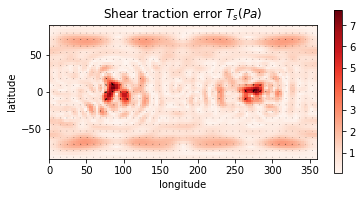

### CASE 4 -- beta:   1.0e+00 gamma:   9.0e-01 rcut/r0:   0.3 noise:  0.01um ###
shape fitting accuracy: 1.433231997638668e-07
Traction residual: 1.5168e+00 Pa
Elastic energy: 3.9581e-04 pJ (true energy 3.9976e-04 pJ)
funval: 2.3006e-04 3.1664e-02 7.3690e-05
Traction error (Pa): emax_Tn =      8.38355768Pa emax_Ts =      6.20455399Pa


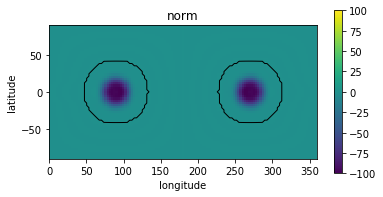

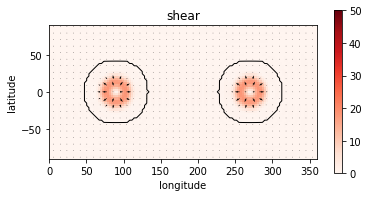

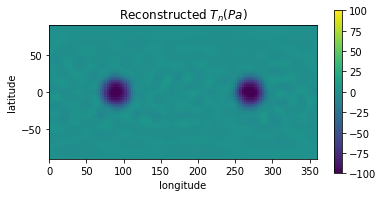

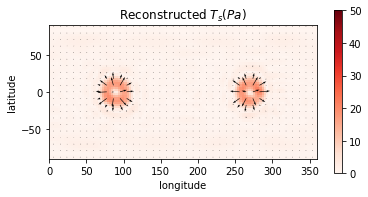

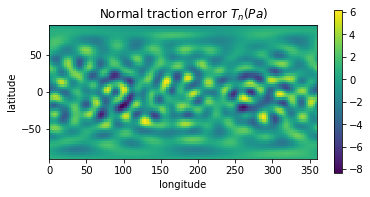

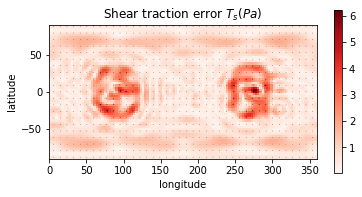

### CASE 5 -- beta:   1.0e+00 gamma:   1.0e+00 rcut/r0:   0.3 noise:  0.01um ###
shape fitting accuracy: 1.433231997638668e-07
Traction residual: 1.4875e+00 Pa
Elastic energy: 3.9656e-04 pJ (true energy 3.9976e-04 pJ)
funval: 2.2127e-04 3.1725e-02 7.1922e-05
Traction error (Pa): emax_Tn =     16.31502833Pa emax_Ts =      9.80146116Pa


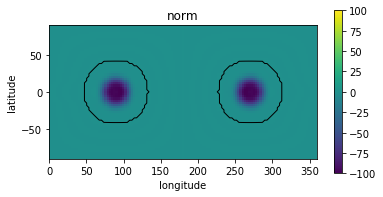

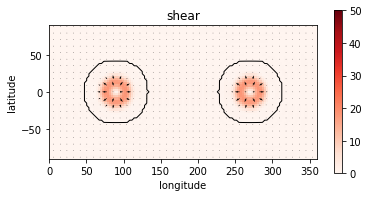

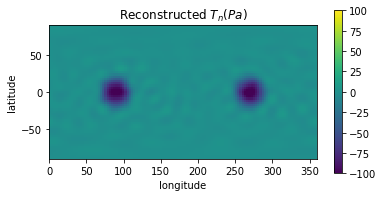

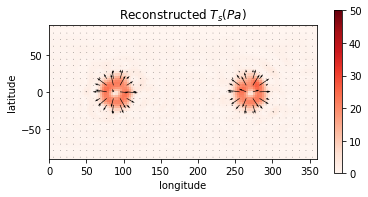

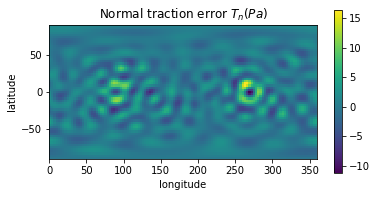

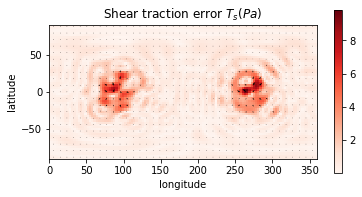

### CASE 6 -- beta:   1.0e+00 gamma:   2.0e+00 rcut/r0:   0.3 noise:  0.01um ###
shape fitting accuracy: 1.433231997638668e-07
Traction residual: 1.2875e+00 Pa
Elastic energy: 3.9531e-04 pJ (true energy 3.9976e-04 pJ)
funval: 1.6576e-04 3.1625e-02 3.9238e-05
Traction error (Pa): emax_Tn =     10.62843171Pa emax_Ts =      8.04326381Pa


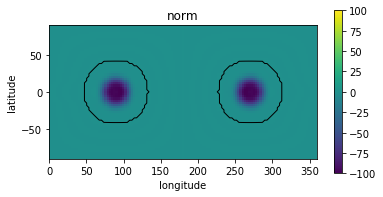

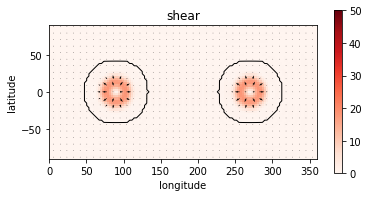

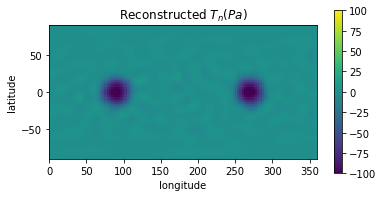

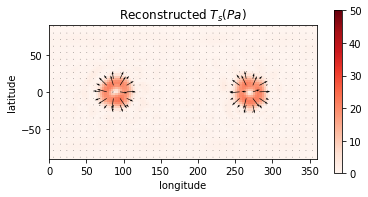

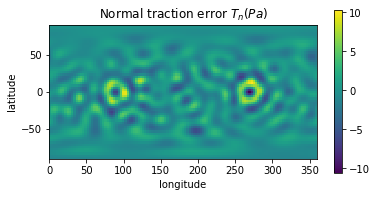

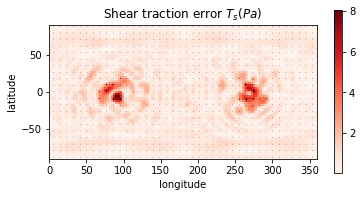

### CASE 7 -- beta:   1.0e+00 gamma:   3.0e+00 rcut/r0:   0.3 noise:  0.01um ###
shape fitting accuracy: 1.433231997638668e-07
Traction residual: 1.6209e+00 Pa
Elastic energy: 3.9535e-04 pJ (true energy 3.9976e-04 pJ)
funval: 2.6273e-04 3.1628e-02 5.4880e-05
Traction error (Pa): emax_Tn =      7.43769980Pa emax_Ts =      7.49656245Pa


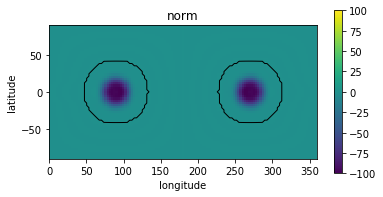

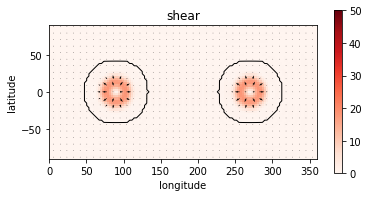

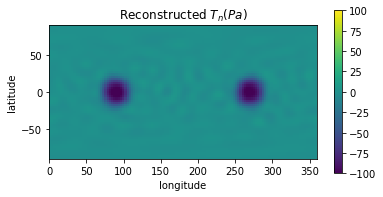

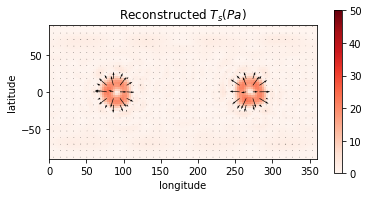

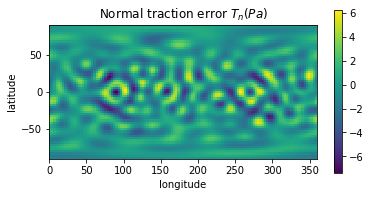

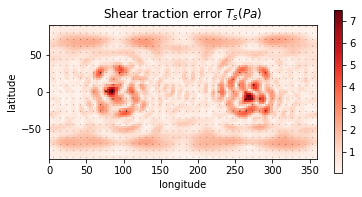

[0.00022587 0.00025791 0.0002454  0.00029039 0.00023006 0.00022127
 0.00016576 0.00026273]
[0.03177666 0.03193373 0.03165244 0.03178876 0.03166449 0.03172509
 0.03162483 0.03162784]
[0.03198054 0.03198054 0.03198054 0.03198054 0.03198054 0.03198054
 0.03198054 0.03198054]


In [5]:
# blist = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
# rlist = np.arange(0.1, 1, 0.2)
# nlist = np.arange(0, 0.06, 0.01)
# blist = [1e-4, 1e-3, 1e-2, 1e-1, 3e-1, 1, 3, 10]
# rlist = np.arange(0.1, 1.1, 0.2)
# nlist = [0.0, 0.0125, 0.025, 0.05]
blist = [1.0, ]
glist = [0.3, 0.5, 0.7, 0.8, 0.9, 1, 2, 3]
rlist = [0.3, ] #0.5, 0.7]
nlist = [0.01, ]

BE, GA, RC, NO = np.meshgrid(blist, glist, rlist, nlist)

BEf = BE.flatten();
GAf = GA.flatten();
RCf = RC.flatten();
NOf = NO.flatten();
eTn = np.zeros_like(GAf)
eTs = np.zeros_like(GAf)
Treslist = np.zeros_like(GAf)
Eel_list = np.zeros_like(GAf)
Epenlist = np.zeros_like(GAf)
Eeltrues = np.zeros_like(GAf)
for i in range(BEf.size):
    beta = BEf[i]; gamma = GAf[i]; rcut = RCf[i]; noise = NOf[i];
    print('### CASE %d -- beta:%10.1e gamma:%10.1e rcut/r0:%6.1f noise:%6.2fum ###'%(i, beta, gamma, rcut, noise))
    Tvec_true, Uvec_true, Vp, Tfv = arbitrary_force(rcut, Cmat=Cmat, Dmat=Dmat)
    f_interp = Ur_interp(Vp/r0, lmax=lJmax+10)
    
    savename = 'AK_noise_b%.0e_g%.0e_r%.1f_n%.1e_lmax%d'%(beta, gamma, rcut, noise, lJmax)
    nfile = len(glob.glob(savename+'_??.npz'))
    if nfile == 0: #not os.path.exists(savename+'.npz'):
        continue
    loadnpz = np.load(savename+'_%02d.npz'%(nfile-1), allow_pickle=True)
    aK = loadnpz['AK_iter']; 
    u_surf = loadnpz['u_surf_list'][-1];
    Uvec = Dmat.dot(aK); Tvec = Cmat.dot(aK)

    isTfv = calculateTfv(Uvec_true, lJmax, Vp/r0, Tfv)

    Tdist = Tvec2Tres(Tvec, lJmax, isTfv=isTfv)
    Eel = np.vdot(Uvec, Tvec).real*2*np.pi # *(r0/1e6)**3*mu0*1e12
    Etrue = np.vdot(Uvec_true, Tvec_true).real*2*np.pi # *(r0/1e6)**3*mu0*1e12
    pen = np.vdot(Q.dot(Tvec), Q.dot(Tvec)).real
    print('Traction residual: %.4e Pa'%(np.sqrt(Tdist)*mu0))
    print('Elastic energy: %.4e pJ (true energy %.4e pJ)'%(Eel*(r0/1e6)**3*mu0*1e12, Etrue*(r0/1e6)**3*mu0*1e12))
    print('funval: %.4e %.4e %.4e'%(Tdist, Eel, pen))
    Treslist[i] = np.copy(Tdist)
    Eel_list[i] = np.copy(Eel)
    Epenlist[i] = np.copy(pen)
    Eeltrues[i] = np.copy(Etrue)
    #print(Treslist, Tdist)
    #print(Eel_list, Eel)
    #print(Eeltrues, Etrue)

    errT = SHVec2mesh((Tvec-Tvec_true)*mu0, lmax=lmax_plot, SphCoord=True, Complex=True)
    eTn[i] = np.abs(errT[...,0]).max()
    eTs[i] = np.linalg.norm(errT[...,1:], axis=-1).max()
    
    fig, ax = visSHVec((Tvec)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                        n_vrange=(-100, 100), s_vrange=(0, 50), show=False,
                         config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))
    ax[0].set_title(r'Reconstructed $T_n(Pa)$')
    ax[1].set_title(r'Reconstructed $T_s(Pa)$')
    print('Traction error (Pa): emax_Tn = %15.8fPa emax_Ts = %15.8fPa'%(np.abs(errT[...,0]).max(), np.linalg.norm(errT[...,1:], axis=-1).max()))
    fig, ax = visSHVec((Tvec-Tvec_true)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, show=False,
                        # n_vrange=(-100, 100), s_vrange=(0, 50),
                        config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))
    ax[0].set_title(r'Normal traction error $T_n(Pa)$')
    ax[1].set_title(r'Shear traction error $T_s(Pa)$')
    plt.show()

print(Treslist)
print(Eel_list)
print(Eeltrues)
#     utrue_fine = SHVec2mesh(Uvec_true*r0 , lmax=lmax_plot, SphCoord=True, Complex=True)
#     ttrue_fine = SHVec2mesh(Tvec_true*mu0, lmax=lmax_plot, SphCoord=True, Complex=True)
#     umesh_fine = SHVec2mesh(Uvec*r0 , lmax=lmax_plot, SphCoord=True, Complex=True)
#     tmesh_fine = SHVec2mesh(Tvec*mu0, lmax=lmax_plot, SphCoord=True, Complex=True)
#     latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lmax_plot)

#     savemat(savename+'.mat', {'Cart_Coords': Vp, 'mask': Tfv, 'r0': r0, 
#                               'latsdeg': latsdeg, 'lonsdeg': lonsdeg,
#                               'Usph_true': utrue_fine, 'Tsph_true': ttrue_fine,
#                               'Usph_mesh': umesh_fine, 'Tsph_mesh': tmesh_fine})

eTn = eTn.reshape(BE.shape)
eTs = eTs.reshape(BE.shape)

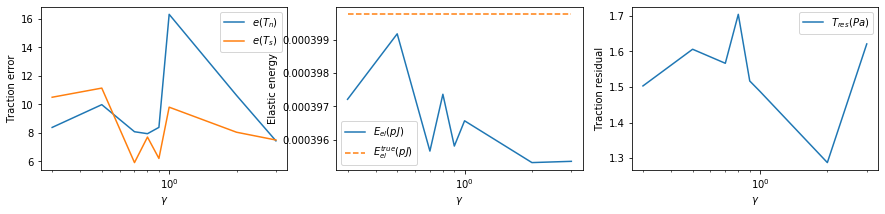

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15,3),sharex=True)
ax[0].semilogx(glist, eTn.flatten(), label=r'$e(T_n)$')
ax[0].semilogx(glist, eTs.flatten(), label=r'$e(T_s)$')
ax[0].set_xlabel(r'$\gamma$')
ax[0].set_ylabel('Traction error')
ax[0].legend()
ax[1].semilogx(glist, Eel_list.flatten()*(r0/1e6)**3*mu0*1e12, label=r'$E_{el}(pJ)$')
ax[1].semilogx(glist, Eeltrues.flatten()*(r0/1e6)**3*mu0*1e12, '--', label=r'$E_{el}^{true}(pJ)$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Elastic energy')
ax[1].legend()
ax[2].semilogx(glist, np.sqrt(Treslist).flatten()*mu0, label=r'$T_{res}(Pa)$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Traction residual')
ax[2].legend()
plt.show()